# Code for generating the UCSC browser track

In [1]:
import warnings
warnings.filterwarnings('ignore')
import polars as pl
import polars.selectors as cs
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
pl.Config.set_fmt_str_lengths(50)
sns.set_style(style='white')
warnings.filterwarnings('ignore')

In [2]:
cd = "/data/cephfs-2/unmirrored/groups/kircher/MPRA/CaptureCMPRA/"

In [3]:
data = pl.read_csv(os.path.join(cd, "results/MPRA_analysis/CMPRA5/labeled_data_promoteroa_OA.tsv"), separator="\t")

In [4]:
data = data.filter(pl.col("promoter") != "null").filter(pl.col("label") != "other - other").filter(np.abs(pl.col("z_score"))>2)

In [5]:
def map_color(z_score):
	if z_score <= -3:
		return "255,0,0"
	elif z_score <= -2:
		return "250,152,156"
	elif z_score >= 3:
		return "13,184,33"
	elif z_score >= 2:
		return "140,255,154"
	else:
		return "227,227,227"

# Example usage
print(map_color(-10))  # Output: "0,0,255" (most saturated blue)
print(map_color(-4))   # Output: "127,127,255" (less saturated blue)
print(map_color(-2.5))   # Output: "191,191,255" (full saturation blue)
print(map_color(-2))   # Output: "223,223,255" (very light blue)
print(map_color(2))    # Output: "255,223,223" (very light red)
print(map_color(3))    # Output: "255,191,191" (full saturation red)
print(map_color(4))    # Output: "255,127,127" (less saturated red)
print(map_color(10))   # Output: "255,0,0" (most saturated red)

255,0,0
255,0,0
250,152,156
250,152,156
140,255,154
13,184,33
13,184,33
13,184,33


In [6]:
bed_format = data.with_columns(pl.col("left_bin").str.split("-"), pl.col("right_bin").str.split("-"))
bed_format = bed_format.select(chrom = pl.col("left_bin").list.get(0), 
					   chromStart = pl.col("left_bin").list.get(1).cast(pl.Int32),
					   chromEnd = pl.col("right_bin").list.get(2).cast(pl.Int32),
					   name = pl.col("label").str.replace_all(" ", ""),
					   score = pl.when(np.abs(pl.col("z_score"))*1000/3 > 1000).then(1000).otherwise(np.abs(pl.col("z_score"))*1000/3).cast(pl.Int32),
					   value = pl.col("z_score").round(3),
					   exp = pl.lit("CMPRA5"),
					   color = pl.col("z_score").map_elements(lambda x: map_color(x)),
					   sourceChrom = pl.col("left_bin").list.get(0),
					   sourceStart = pl.col("left_bin").list.get(1).cast(pl.Int32),
					   sourceEnd = pl.col("left_bin").list.get(2).cast(pl.Int32),
					   sourceName = pl.col("targeted_left"),
					   sourceStrand = pl.lit("."),
					   targetChrom = pl.col("right_bin").list.get(0),
					   targetStart = pl.col("right_bin").list.get(1).cast(pl.Int32),
					   targetEnd = pl.col("right_bin").list.get(2).cast(pl.Int32),
					   targetName = pl.col("targeted_right"),
					   targetStrand = pl.lit("."),
					   #lineWidth = ((pl.col("nr_reads") - pl.col("nr_reads").min())/(pl.col("nr_reads").max() - pl.col("nr_reads").min())*10 + 1).clip(upper_bound=3)
)

#pl.when(pl.col("z_score") > 2).then(pl.lit("#ff1f23"))
					#    .when((pl.col("z_score") < 2) & (pl.col("z_score") > 0)).then(pl.lit("#ffd1d2"))
					#    .when(pl.col("z_score") < -2).then(pl.lit("#1f24ff"))
					#    .otherwise(pl.lit("#d1d2ff")),


<Axes: xlabel='lineWidth', ylabel='Count'>

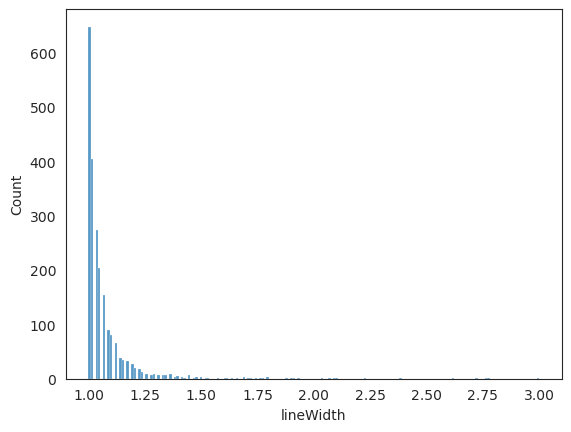

In [7]:
sns.histplot(bed_format.to_pandas(), x="lineWidth") #, bins=100, kde=True)

In [7]:
bed_format = bed_format.sort("chrom", "chromStart")

In [11]:
bed_format.write_csv("../../results/UCSC_browser_track/CMPRA5_withLineWidth.interact.bed", separator="\t")

In [8]:
bed_format.write_csv(os.path.join(cd, "results/UCSC_browser_track/CMPRA5_significant.bed"), separator="\t")